In [45]:
using Plots, NamedTuples, DifferentialEquations, StatsBase
Plots.gr()

Plots.GRBackend()

# Introduction

In this notebook I will do some preliminary simulations for the heterotroph model. 

The basic model for carbon biomass change of a single species is:

\begin{align}
\frac{dC_i}{dt} = C_i \left(\epsilon_i V_{C_i} \mu_i - R_i\right)
\end{align}

where 
\begin{align}
 V_{C_i} = \frac{C} { max(0,k_{s_i} + \sum_{j = 0}^{n} a_{ij} C_j) + C}
\end{align}

Thus the interaction between species is realised through their ability to alter the half-saturation constants of others. the term $a_{ij}$ describes the nature of the effect of species $j$ on species $i$ and can be positive (meaning it reduces the ability of the species $i$ to uptake carbon) or negative (meaning the opposite). The total value of $k_{s_i}$ can never go below 0 as this makes no sense in the monmod function. 

The value of $C$ (the carbon pool) is tracked with a seperate equation where:

\begin{align}
\frac{dC}{dt} = -\sum_{n}^{i=0} C_i \epsilon_i V_{C_i} \mu_i
\end{align}

so there is no replenishment of carbon with the only carbon being taken out being that that is assimilated into biomass (We assume that the rest is returned to the shared carbon pool instantaneously)


## Temperature dependence

We represent the temperature dependence of both carbon uptake ($/mu$) and respiration ($R$) using the boltzmann-arrenhius equation which allows their temperature dependence to be characterised. 

# The model
First i define some helper functions

In [14]:
#Defining the model

#helper functions
#monmod
function monmod(S::Float64,ks::Float64)
    return(S / (ks + S))
end

#modified boltzman with Tref (Note Temperature is all in Kelvin)
function boltz(B0,E,Tref,T)
    return(B0 * exp((-E/8.617e-5) * ((1/T)-(1/Tref)) ))
end

boltz (generic function with 1 method)

And then some new types for parameter storage

In [15]:
#Species type
struct Species
        u0::Float64
        Eu::Float64
        r0::Float64
        Er::Float64
        kc0::Float64
        e::Float64
end

#parameter type
struct Parameter
        sp::Vector{Species}
        a::Array{Float64,2}
        T::Float64
        Cr::Float64
end


Then i define the problem (i.e. the dc/dt)

In [16]:
function dcdt(dc,c,p,t)
    for i = 1:(length(dc)-1)
        
        #calculate kci
        kc = p.sp[i].kc0
        for j = 1:(length(dc)-1)
            kc += p.a[i,j] * c[j]
        end
        
        #calculate biomass change
        dc[i] = (p.sp[i].e * boltz(p.sp[i].u0,p.sp[i].Eu,293.15,p.T) * monmod(c[end],max(kc,0))) -
                boltz(p.sp[i].r0,p.sp[i].Er,293.15,p.T)
        
        dc[end] += p.Cr -(p.sp[i].e * boltz(p.sp[i].u0,p.sp[i].Eu,293.15,p.T))
        
        for i = 1:length(dc)
            if(c[i] + dc[i] < 0)
                dc[i] = -c[i]
            end
        end
    end
end

dcdt (generic function with 1 method)

# Simulations

First i need to parameterise the model. First I will look at the simple case of two symetrically competing species (i.e. $a_{ij} = a_{ji}$)

In [143]:
#define species 
Species1 = Species(10.0,0.75,1.0,1.08,1,0.3)
Species2 = Species(10.0,0.65,1.0,0.98,1,0.3)

#define comp matrix 
a = [1.0 2.0 ; 2.0 1.0]

#define parameters
p = Parameter([Species1,Species2],a, 293.15,0.0)

Parameter(Species[Species(10.0, 0.75, 1.0, 1.08, 1.0, 0.3), Species(10.0, 0.65, 1.0, 0.98, 1.0, 0.3)], [1.0 2.0; 2.0 1.0], 293.15, 0.0)

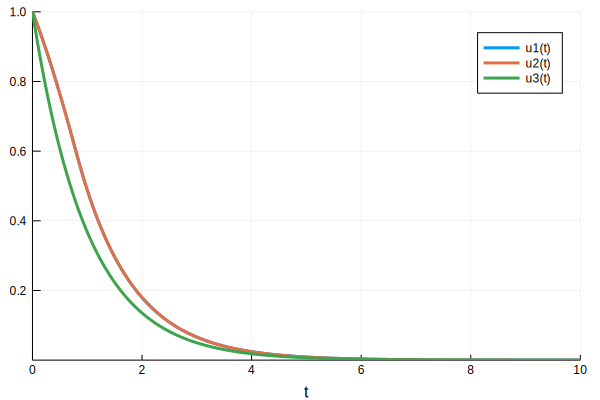

In [144]:
# do the simulation
dc = zeros(3)
c0 = [1.0,1.0,1.0]

prob = ODEProblem(dcdt,c0,(0,10.0),p)
sol = solve(prob)
plot(sol)

In [145]:
function Tsim(T,r)
    p = Parameter([Species1,Species2],a, T,r)
    prob = ODEProblem(dcdt,c0,(0,100.0),p)
    sol = solve(prob)
    return(sol)
end


Tsim (generic function with 2 methods)

In [148]:
Tsim(310,13)[end] , Tsim(300,13)[end]

LoadError: [91mSomething went wrong. Integrator stepped past tstops but the algorithm was dtchangeable. Please report this error.[39m

Interesting result here. We can only change the total biomass in the system by altering efficency. With a set $/epsilon$ the finite amount of carbon in the common pool should always result in the same total biomass. This is altered only if the efficency of the conversion changes. Dynamics may change the temporal scale of this though integrated across time the biomass will always be the same. 

In systems with carbon influx this also has relevance. if we assume that competition is mediated through the avalibility of carbon then epsilon provides a finite limit on species growth. So as i thoug before the problem becomes one of two phases
- The exponential phase
- The carbon limited phase

In the exponential phase there is no competition for resources (we assume) meaning that growth is fully realised (i.e. $V_C$ \approx 1$) in this case the growth reduces down to 

\begin{align}
\frac{dC_i}{dt} = C_i \left(\epsilon_i \mu_i - R_i\right)
\end{align}

which is just the exponential model (if we substitute $r = (\epsilon_i \mu_i - R_i)$). Thus we 


# What would an autotroph model look like?

In an autotroph model the mechanism of competiton Invoked here is assumed not to be relevant. this is because autotrophs can be thought of as non-cabon limited. Instead competition for a shared resource is more likely which can be represented as carbon in the heterotroph model. This requires knowledge of the ratios of nutrient uptake to carbon uptake (and allow stoichiometry). 

gi7147

# Exponential growth
I had an idea. If an organism is in exponential growth then we can get the growth rate by looking at the slope of the line in log space:

\begin{align}
    r = \frac{log(t_2)-log(t_1)}{t_2 - t_1}
\end{align}

this is constant where ever we look at the growth rate:

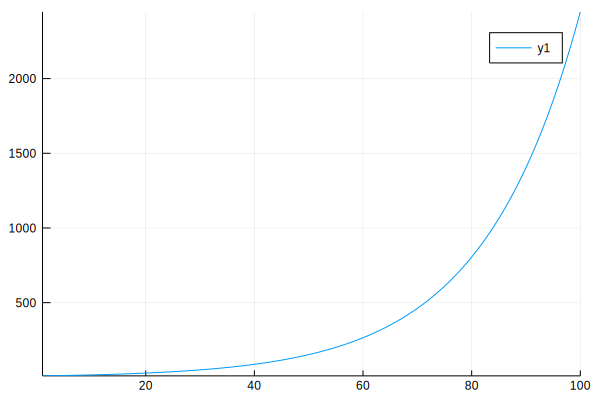

In [104]:
function growth(n0,r,t)
    n0 * exp(r*t)
end

tvec = collect(linspace(0,5,100))
mass = [growth(10,1.1,t) for t in tvec]
plot(mass)

In [118]:
function growthrate(n1,n2,t1,t2)
   (log(n2)-log(n1)) / (t2-t1)
end



t_s = [sample(1:100,100)  sample(1:100,100)]
results = zeros(100)

for i = 1:100
    min = minimum(t_s[i,:])
    max = maximum(t_s[i,:])
    results[i] = growthrate(mass[min],mass[max],tvec[min],tvec[max])
end

results = results[.!isnan.(results)]
summarystats(results)

Summary Stats:
Mean:           1.100000
Minimum:        1.100000
1st Quartile:   1.100000
Median:         1.100000
3rd Quartile:   1.100000
Maximum:        1.100000


The problem comes that in the real world individuals will grow to asymptopically. thus the growth model looks more like:

\begin{align}
\frac{dN}{dt} = rN (k - N)
\end{align}

so as N approaches K the value of $(k - N)$ goes to 0 as does growth rate.

We can plot this:

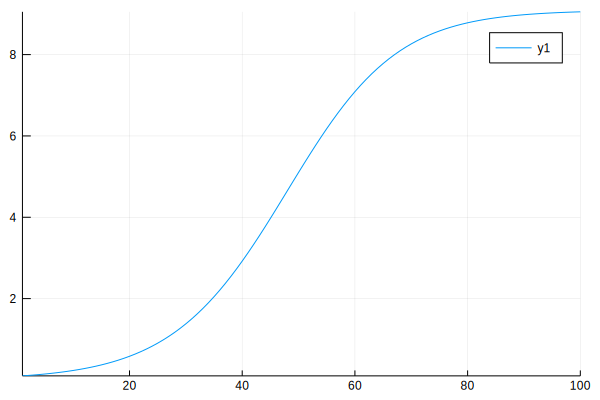

In [140]:
function logistic(n,r,k)
    r*n*(1 - (n/k))
end

#growthloop
N = Vector(100)
N[1] = 0.1

for i = 2:100
    N[i] = logistic(N[i-1],1.1,100)
end

plot(N)

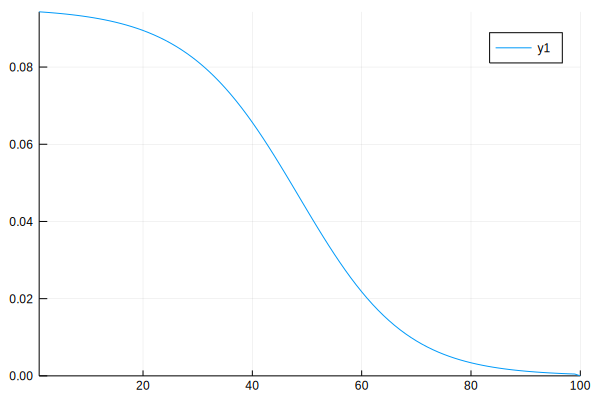

In [142]:
results = zeros(100)

for i = 2:100
    results[i-1] = growthrate(N[i-1],N[i],i-1,i)
end


plot(results)

In [134]:
0.1*1.1 * (0.1/10000)

1.1000000000000003e-6